# Analyzing subject mentions

**subject mentions** == The subject mentioning other users.

We will be looking at two things:
- distribution of total mentions
- top-K mentioned people (and how many times they were mentioned)

*Total mentions* == Sum of all the mentions of one subject.

## Some conclusions
Ran with the following numbers:
```
N_SUBJECTS = 100
TOP_K_MENTIONS = 15
N_TWEETS = 200
```
- Total number of mentions are between 0-200 for ~200 tweets / user.
- It seems like most users mention only a handful of users (1-5) more frequently.

__Notes__:
We also looked at *mutual* mentions -- unfortunately among the first 100 subjects there were none, thus I excluded them from the analysis.

In [5]:
%load_ext dotenv
%dotenv 

In [40]:
from pymongo import MongoClient
import os
import pandas as pd
import plotly.express as px
from collections import Counter

In [120]:
N_SUBJECTS = 100
TOP_K_MENTIONS = 15
N_TWEETS = 200

In [154]:
mongo_conn = MongoClient(os.environ["MONGO_CONN"])
db = mongo_conn.twitter  # our database

sampled_users_collection = db["sampled_users_collection"]
timelines_collection = db["timelines_collection"]
mentions_collection = db["mentions_collection"]

Get cursor for subjects

In [179]:
set_RT_ratio = {
    "$set": {"RT_ratio": {"$divide": ["$num_RT_tweets", "$num_pulled_tweets"]}},
}

subjects_filter = {
    "$match": {
        "error_or_no_access": False,
        "majority_lang": "en",
        "num_pulled_tweets": {"$gt": 0},
        "tweet_count": {"$gt": 200},
        "RT_ratio": {"$lt": 0.8},
        "bot_score.raw_scores.english.overall": {"$lt": 0.5},
    }
}

limit = {"$limit": N_SUBJECTS}

cursor = sampled_users_collection.aggregate([set_RT_ratio, subjects_filter, limit])

In [180]:
subjects = []

for s in cursor:
    data = {
        "username": s["username"],
        "mentions": Counter(),
        # "mentioned_by": Counter(),
        "total_mentions": 0,
        # "total_mentioned_by": 0
    }
    
    user_timeline_no_RT = {
        "author_id": s["id"],
        "referenced_tweets.0.type": {"$ne": "retweeted"},
    }
    
    # timeline
    t_cursor = timelines_collection.find(user_timeline_no_RT).limit(N_TWEETS)
    
    for t in t_cursor:
        if "entities" in t and "mentions" in t["entities"]:
            usernames = [mention["username"] for mention in t["entities"]["mentions"]]
            data["mentions"] = data["mentions"] + Counter(usernames)
    
    data["total_mentions"] = len(list(data["mentions"].elements()))
    
#     user_mentions = {
#         "mentioned_user_id": s["id"],
#     }
    
#     # mentions timeline
#     m_cursor = mentions_collection.find(user_mentions)
#     for m in m_cursor:
#         data["mentioned_by"] = data["mentioned_by"] + Counter([m["id"]])
        
#     data["total_mentioned_by"] = len(list(data["mentioned_by"].elements()))
    
    subjects.append(data)
        
subjects = sorted(subjects, key=lambda d: d["total_mentions"]) # sort subjects by total mentions

In [181]:
subjects

[{'username': 'metacritic',
  'mentions': Counter({'DawnX90': 1,
           'danielletbd': 1,
           'TVGuide': 1,
           'MeggoInc': 1,
           'GameSpot': 1,
           'ChrisHayner': 1,
           'mgmstudios': 2,
           'UniversalPics': 1,
           'NaughtyNDC': 1}),
  'total_mentions': 10},
 {'username': 'radiantlyblack',
  'mentions': Counter({'tattedmommy____': 3,
           'Parlaye_': 1,
           'LotsofDinero': 1,
           'UglyAssDoobie': 1,
           'deeski___': 1,
           'DoorDash': 1,
           'littlecaesars': 1,
           'Claressashields': 1}),
  'total_mentions': 10},
 {'username': 'Jaymone56782656',
  'mentions': Counter({'thebettingqueen': 1,
           'BetOnSarah': 1,
           'AlphaDogBets': 1,
           'BetUS_Official': 1,
           'RoyalLocks1': 1,
           'PlatinumsBets': 1,
           'Prodigy_Bets': 3,
           'laurencowling_': 1,
           'RBsSportsPlays': 1,
           'SurgicalPlayss': 5,
           'GhostfaceBet

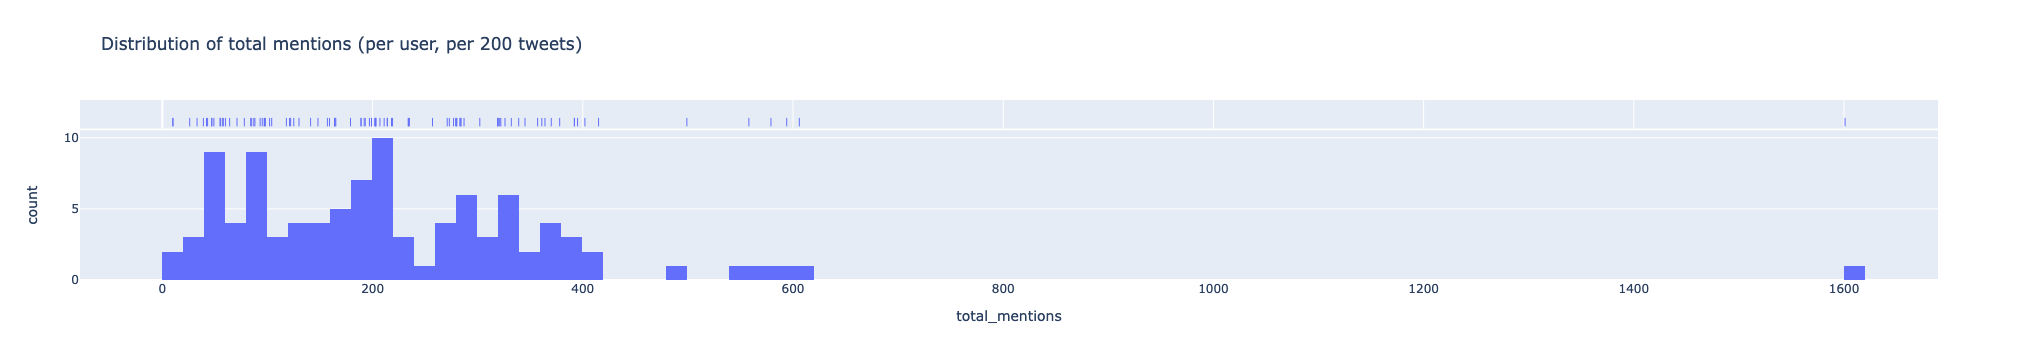

In [188]:
px.histogram(subjects, x="total_mentions", nbins=100, labels={"x": "Number of total mentions"}, marginal="rug", hover_name="username", title="Distribution of total mentions (per user, per %d tweets)" % N_TWEETS)

In [183]:
data = {
    "subjects": [],
    "top-k": [],
    "mentioned_user": [],
    "mentions": []
}

for s in subjects:
    k = 0
    for uname, n_mentions in s["mentions"].most_common():
        if k >= TOP_K_MENTIONS:
            break
        k += 1
        data["subjects"].append(s["username"])
        data["top-k"].append(str(k))
        data["mentioned_user"].append(uname)
        data["mentions"].append(n_mentions)

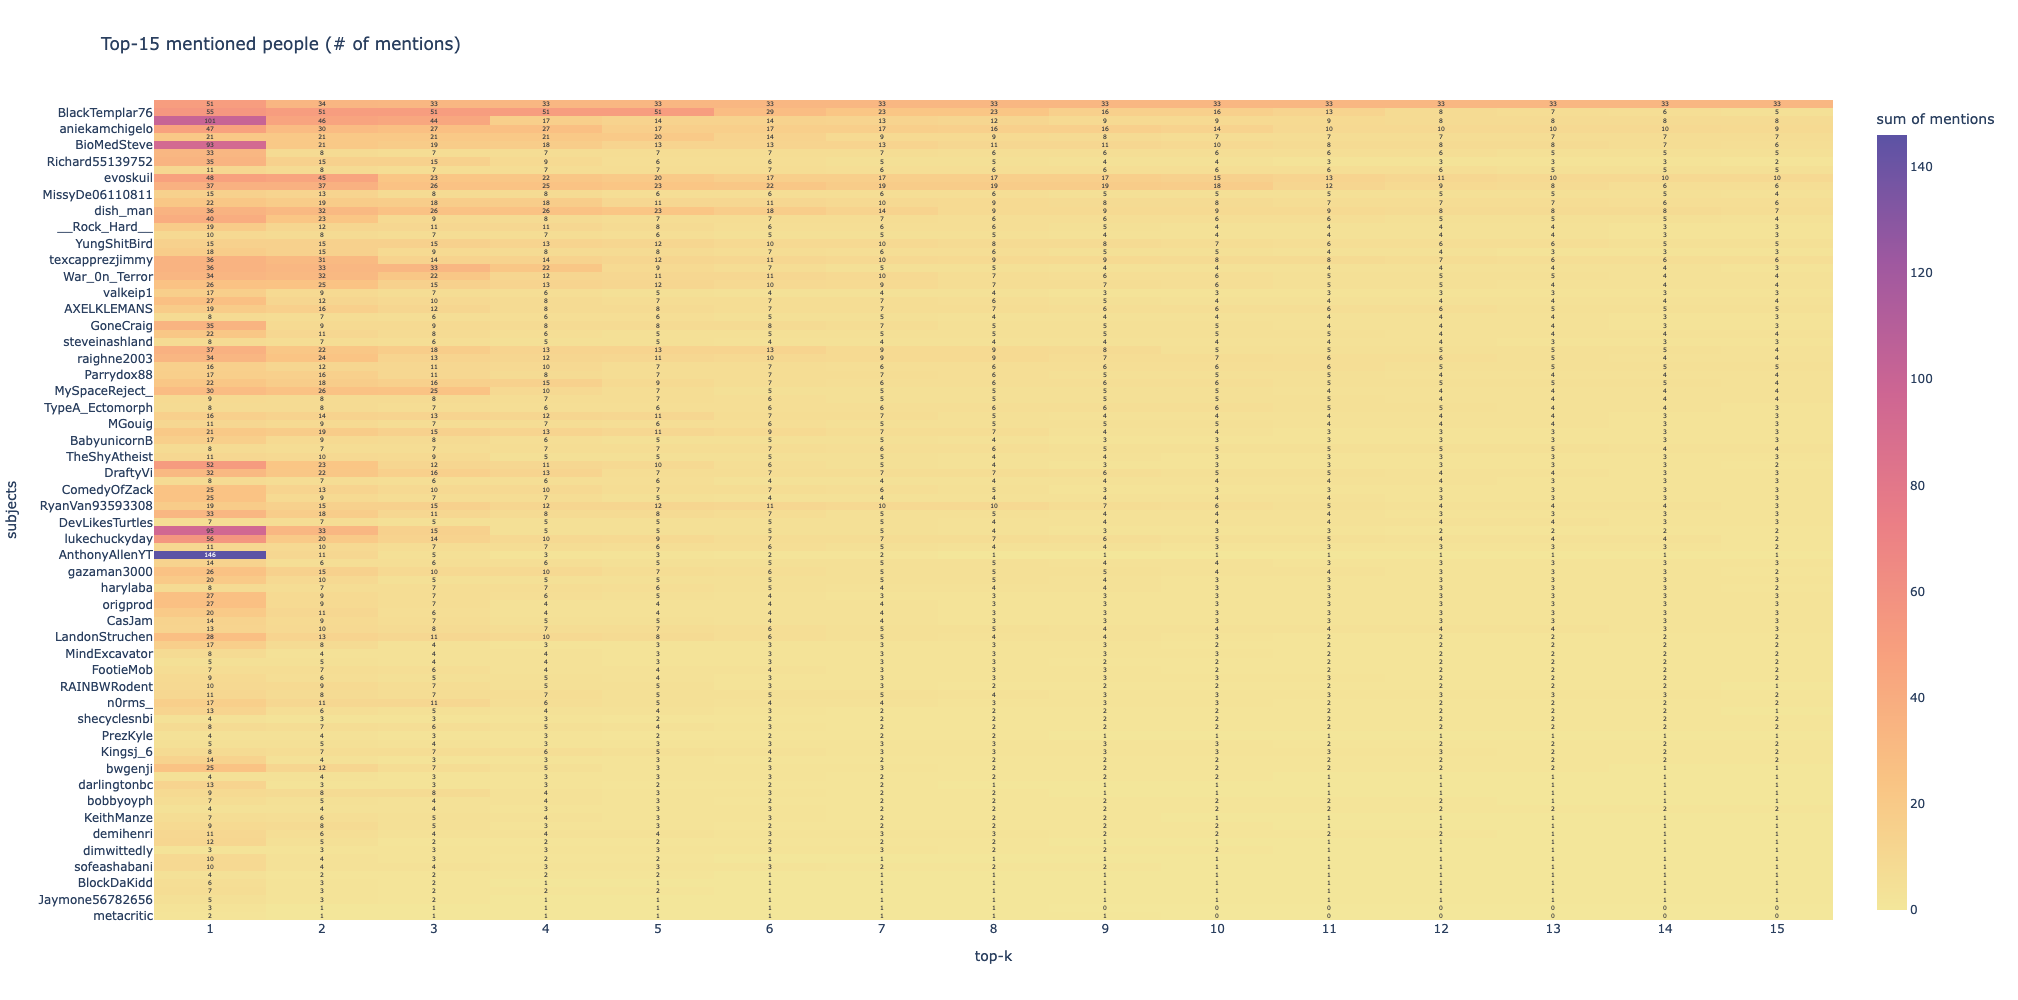

In [186]:
df = pd.DataFrame.from_dict(data)

fig = px.density_heatmap(df, x="top-k", y="subjects", z="mentions", text_auto=True, height=1000, color_continuous_scale="sunset", title="Top-%d mentioned people (# of mentions)" % TOP_K_MENTIONS)
fig.update_xaxes(type='category')
fig.show()

In [191]:
df[df["mentions"] == 146]

,subjects,top-k,mentioned_user,mentions
647,AnthonyAllenYT,1,YouTube,146


Maybe filter out verified businesses from peers? - **No**, doesn't really pay off...

`verified_type: 'business'` (< 1% of accounts in users_collection, other types: `'blue'`). 

VERY new feature: [added](https://github.com/twitter-dart/twitter-api-v2/issues/646) on Feb 2nd 2023!

Examples:

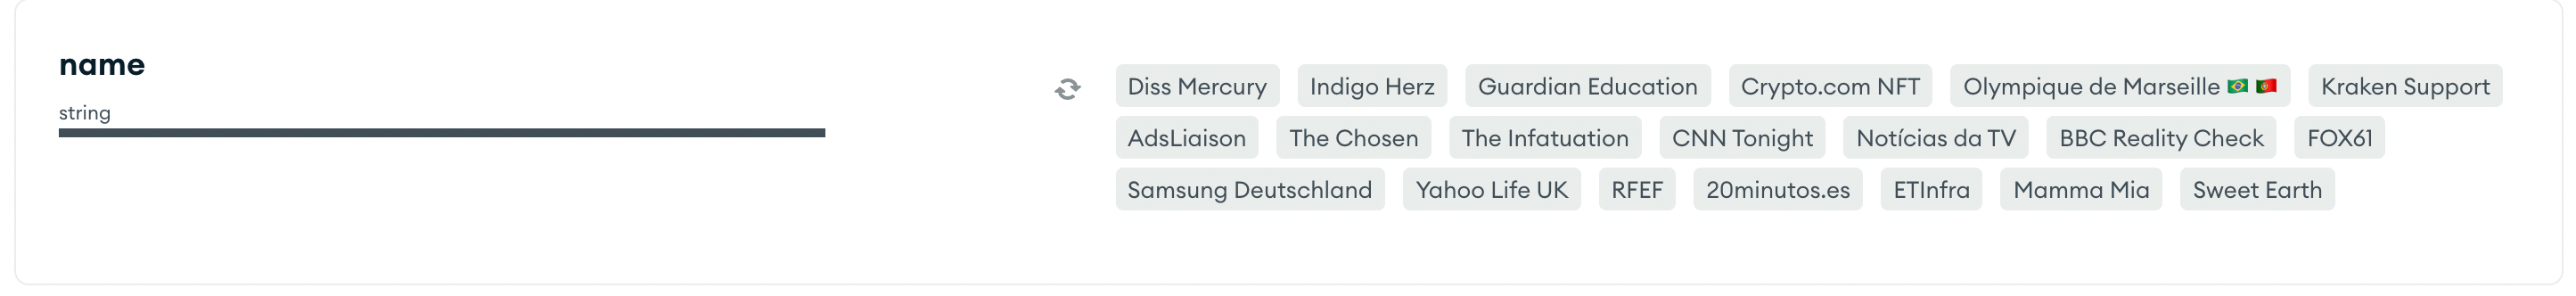

### Test plots on dummy data

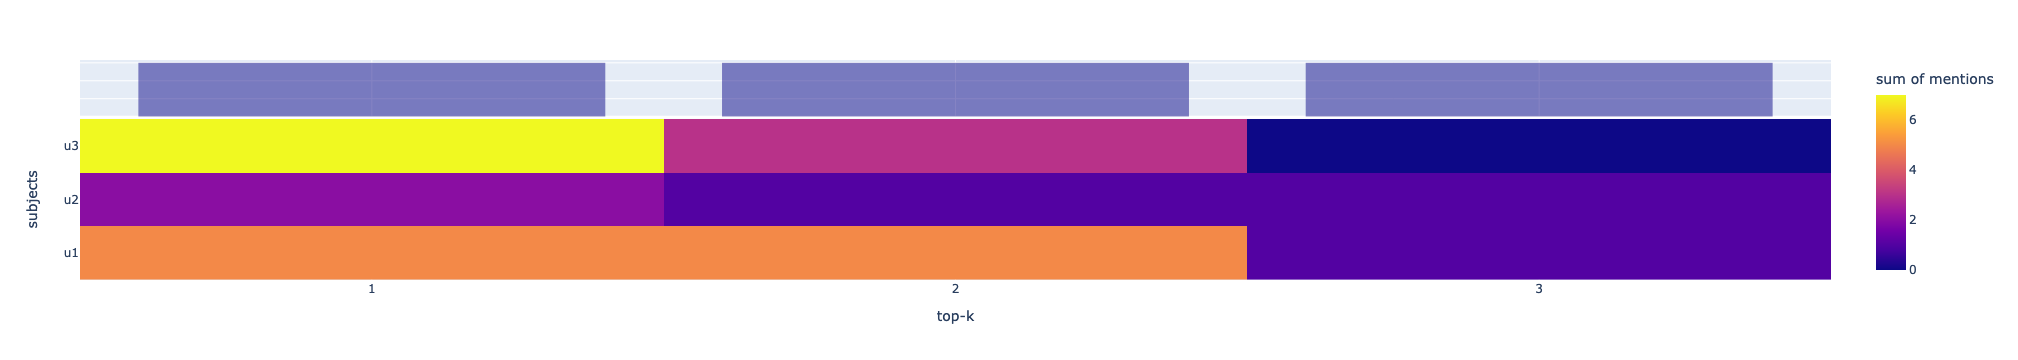

In [65]:
dummy_data = {
    "subjects": ["u1", "u1", "u1", "u2", "u2", "u2", "u3", "u3", "u3"],
    "top-k": ["1", "2", "3", "1", "2", "3", "1", "2", "3"],
    "mentions": [5, 5, 1, 2, 1, 1, 7, 3, 0]
}

df = pd.DataFrame.from_dict(dummy_data)

fig = px.density_heatmap(df, x="top-k", y="subjects", z="mentions", marginal_x="histogram")
fig.show()